## Analyzing Stanford Open Policing Project Database

#### We study the Traffic Stops made by Police in the state of Rhode Island from the Stanford Open Policing Project Database to understand the correlation between gender, race, time of the day, weather and locality on police traffic stops, searches, arrests among other things.

#### Throughout this analysis, we ask questions and try to answer them by forming meaningful comparisons and visualizations between the different attributes.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


data_file='https://assets.datacamp.com/production/repositories/1497/datasets/62bd9feef451860db02d26553613a299721882e8/police.csv'
ri=pd.read_csv(data_file)

In [12]:
#dropping county_name since most 99% of values are Null, State is same Rhode Island for all rows
ri.drop(['county_name','state'], axis='columns', inplace=True)

#dropping rows without driver_gender since it is very essential for analysis, around 5k of 92k rows dropped 
ri.dropna(subset=['driver_gender'], inplace=True)

#change the dtype of is_arrested column from object(string) to boolean
ri['is_arrested']=ri['is_arrested'].astype('bool')

#creating a combined pandas datetime column
comb=ri.stop_date.str.cat(ri.stop_time, sep=' ')
ri['stop_datetime']=pd.to_datetime(comb)

#set the pandas datetime column as index for ease of accessing and wrangling data
ri.set_index('stop_datetime', inplace=True)

#Comparison of Violation Types across genders
print(ri.groupby(['driver_gender']).violation.value_counts(normalize=True))

driver_gender  violation          
F              Speeding               0.658114
               Moving violation       0.138218
               Equipment              0.105199
               Registration/plates    0.044418
               Other                  0.029738
               Seat belt              0.024312
M              Speeding               0.522243
               Moving violation       0.206144
               Equipment              0.134158
               Other                  0.058985
               Registration/plates    0.042175
               Seat belt              0.036296
Name: violation, dtype: float64


<b>We find that SPEEDING constitutes half of violations in Men, but 2/3rd violations in Women</b>

In [13]:
# --> Is there a correlation between gender and being searched on traffic stops by Police?
print("Correlation between Gender and Search Conducted")
print(ri.groupby('driver_gender').search_conducted.mean())

# ---We find Men are subject to searches more than twice as often as women---
# ---But, this might be influenced by the type of violation too, so we examine furthe---
print("\n")
print(ri.groupby(['violation','driver_gender']).search_conducted.mean())
# --- The above data clearly shows that Men are searched more often than Women even if we factor in Violtion types---


Correlation between Gender and Search Conducted
driver_gender
F    0.019181
M    0.045426
Name: search_conducted, dtype: float64


violation            driver_gender
Equipment            F                0.039984
                     M                0.071496
Moving violation     F                0.039257
                     M                0.061524
Other                F                0.041018
                     M                0.046191
Registration/plates  F                0.054924
                     M                0.108802
Seat belt            F                0.017301
                     M                0.035119
Speeding             F                0.008309
                     M                0.027885
Name: search_conducted, dtype: float64


<b>The above data clearly shows that Men are searched more often than Women even if we factor in Violation types</b>

In [14]:
# --> Do Men get frisked more than women?

ri['frisk']=ri.search_type.str.contains('Frisk', na=False)

#
print(ri[ri['search_conducted']==True].groupby('driver_gender')['frisk'].value_counts(normalize=True))

driver_gender  frisk
F              False    0.925439
               True     0.074561
M              False    0.905647
               True     0.094353
Name: frisk, dtype: float64


<b>We see that Men get frisked a little more often than Women</b>

Mean Arrest Rate:0.0355690117407784


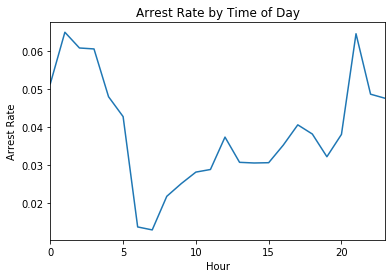

In [15]:
# --> Hourly Arrest rates in a 24-hr cycle

print("Mean Arrest Rate:"+str(ri.is_arrested.mean()))

# Calculate the hourly arrest rate
ri.groupby(ri.index.hour).is_arrested.mean()

# Save the hourly arrest rate
hourly_arrest_rate = ri.groupby(ri.index.hour).is_arrested.mean()

# Create a line plot of 'hourly_arrest_rate'
hourly_arrest_rate.plot()

# Add the xlabel, ylabel, and title
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')

# Display the plot
plt.show()

<b>We see that Arrest rates peak from 8pm to 3am</b>

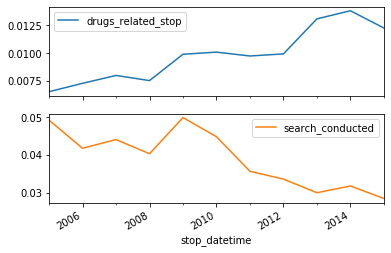

In [16]:
#--> Have Drug-related stops increased over the years?

# Save the annual rate of drug-related stops
annual_drug_rate = ri.drugs_related_stop.resample('A').mean()

# Calculate and save the annual search rate
annual_search_rate = ri.search_conducted.resample('A').mean()

# Concatenate 'annual_drug_rate' and 'annual_search_rate'
annual = pd.concat([annual_drug_rate,annual_search_rate], axis='columns')

# Create subplots from 'annual'
annual.plot(subplots=True)

# Display the subplots
plt.show()

<b> We see that drug-related stops have increased even though there's a decreasing trend in search_conducted</b>

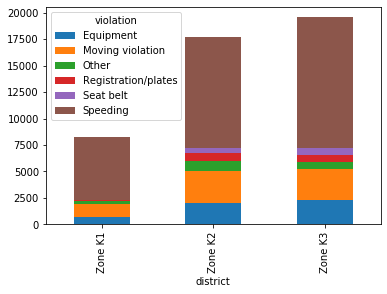

In [17]:
# --> What kind of violations occur in each district

# Create a frequency table of districts and violations
all_zones = pd.crosstab(ri.district,ri.violation)

# Select rows 'Zone K1' through 'Zone K3'
k_zones = all_zones.loc['Zone K1':'Zone K3']

# Create a stacked bar plot of 'k_zones'
k_zones.plot(kind='bar',stacked=True)

# Display the plot
plt.show()

<b> We observe that the violation distribution is similar in ZoneK2 and ZoneK3, ZoneK1 has most of its stops due to speeding</b>

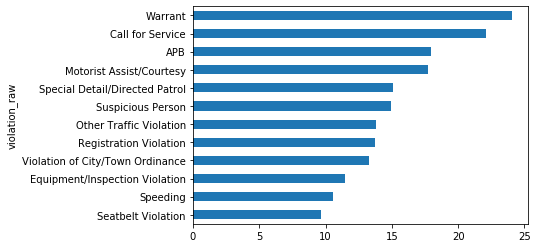

In [18]:
# -->How long are you likely to be stopped for different types of stops?

# Create a dictionary that maps strings to integers
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min':45}

# Convert the 'stop_duration' strings to integers using the 'mapping'
ri['stop_minutes'] = ri.stop_duration.map(mapping)

# Calculate the mean 'stop_minutes' for each value in 'violation_raw'
stop_length = ri.groupby('violation_raw').stop_minutes.mean()

# Sort 'stop_length' by its values and create a horizontal bar plot
stop_length.sort_values().plot(kind='barh')

# Display the plot
plt.show()

<b> We can infer that Warrnted stops last for max time while seatbelt violation stops are for the least time </b>

In [19]:
# Effect of Weather of the day and policing
# We import Weather data for Rhode Island and merge the two to find correlations 

# Read 'weather.csv' into a DataFrame named 'weather'
weather_csv='https://assets.datacamp.com/production/repositories/1497/datasets/02f3fb2d4416d3f6626e1117688e0386784e8e55/weather.csv'
weather=pd.read_csv(weather_csv)

# Copy 'WT01' through 'WT22' to a new DataFrame, where WTxx represents a particular harsh weather condition, with 1 for such a condition present and 0 for absent
WT = weather.loc[:,'WT01':'WT22']

# Calculate the sum of each row in 'WT'
weather['bad_conditions'] = WT.sum(axis='columns')

# Replace missing values in 'bad_conditions' with '0'
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad',4:'bad',5:'worse',6:'worse',7:'worse',8:'worse',9:'worse'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

# Count the unique values in 'rating'
#print(weather.rating.value_counts())



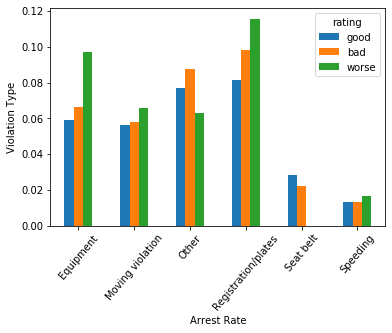

In [20]:
# Create a list of categories
cats=['good','bad','worse']

# Change the data type of 'rating' to category
weather['rating'] = weather.rating.astype('category', category=cats)

# Reset the index of 'ri'
ri.reset_index(inplace=True)

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating=weather[['DATE','rating']]

# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('stop_datetime', inplace=True)

# Create a Pivot table for Violation and Rating of is_arrested
arrest_rate= ri_weather.pivot_table(index='violation', columns='rating', values='is_arrested')
arrest_rate=arrest_rate[['good','bad','worse']]

# Plot the graph of Arrest Rate for different violation types under good, bad or worse weather ratings
arrest_rate.plot(kind='bar')
plt.xlabel('Arrest Rate')
plt.xticks(rotation=50)
plt.ylabel('Violation Type')
plt.show()

<b> We find that there's a positive correlation between bad weather and arrest rate. This only implies correlation, but doesn't necessarily imply causation.</b>